In [1]:
import numpy as np
import pandas as pd 
import sklearn
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pickle
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [2]:
for p in [np, pd, sklearn, lgb]:
    print (p.__name__, p.__version__)

numpy 1.14.5
pandas 0.19.2
sklearn 0.19.0
lightgbm 2.0.6


# Predicting future sales

In [3]:
sales = pd.read_csv('sales_train.csv.gz')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv')

Number of shops was not that big, so I manually created some features for shops and introduced them into source file. There I already have shops dataframe with my additional features. 'City' here nearly corresponds to distinct city, and Internet for Internet shops is considered as a distinct place. 'Location' corresponds to building, which seems to be the same for some shops (for instance, for shops 0 and 57). 'kindaMoscow' reflects if the city is located in Moscow region. 'IsMega' determines if shop belongs to 'Mega' retail network.

In [4]:
shops.head()

,shop_name,shop_id,city,location,kindaMoscow,isMega
0,"!Якутск Орджоникидзе, 56 фран",0,0,0,0,0
1,"!Якутск ТЦ ""Центральный"" фран",1,0,1,0,0
2,"Адыгея ТЦ ""Мега""",2,1,2,0,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,2,3,1,0
4,"Волжский ТЦ ""Волга Молл""",4,3,4,0,0


In the next cell I create features for cumulative sales for each month and for mean price for combination of item and month (i.e mean price between all shops for each item in each month).

In [4]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Groupby data to get item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_price':{'price':'mean'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [5]:
all_data.head()

,shop_id,item_id,date_block_num,target,price,target_shop,target_item
0,59,22154,0,1.0,999.000000,2017.0,18.0
1,59,2552,0,0.0,899.000000,2017.0,0.0
2,59,2554,0,0.0,1709.050049,2017.0,1.0
3,59,2555,0,0.0,1098.849976,2017.0,2.0
4,59,2564,0,0.0,327.600006,2017.0,5.0


In next few cells I expand test dataframe and merge it with train dataframe for further feature generation.

In [6]:
test['date_block_num'] = 34
test['target'] = 0
test['price'] = 0
test['target_shop'] = 0
test['target_item'] = 0
test_shorted = test.drop(['ID'], axis=1)

In [7]:
dates = all_data['date_block_num']
X_prev_month =  all_data.loc[dates == 33]

In [8]:
test_shorted = pd.merge(test_shorted, X_prev_month[['item_id', 'price']].groupby(['item_id'],as_index=False).mean(), how='left', on=['item_id']).fillna(0)

In [9]:
test_shorted['price_x'] = test_shorted['price_y']
test_shorted = test_shorted.drop(['price_y'], axis=1)
test_shorted = test_shorted.rename(index=str, columns={"price_x": "price"})

In [10]:
test_shorted.head()

,shop_id,item_id,date_block_num,target,price,target_shop,target_item
0,5,5037,34,0,1499.00000,0,0
1,5,5320,34,0,0.00000,0,0
2,5,5233,34,0,1199.00000,0,0
3,5,5232,34,0,1190.43335,0,0
4,5,5268,34,0,0.00000,0,0


In [11]:
all_data = pd.concat([all_data, test_shorted], axis=0, join='outer', join_axes=None, ignore_index=True,
          keys=None, levels=None)

Next I create lagged features for cumulative sales and prices.

In [12]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


After some tests I discovered, that so many lagged price features doesn't help to make predictions better, so I discarded all of them except price with lag of 1 month.

In [13]:
all_data = all_data.drop(['price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5', 'price_lag_12'], axis=1)

In [14]:
all_data.head()

,shop_id,item_id,date_block_num,target,price,target_shop,target_item,price_lag_1,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,749.000000,8198.0,23.0,741.560730,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,1569.647095,8198.0,17.0,1599.000000,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,394.649353,8198.0,182.0,392.347504,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,699.000000,8198.0,26.0,682.033325,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,299.000000,8198.0,3.0,266.000000,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


Then I clipped sales to [0, 20] interval.

In [15]:
cols_to_clip = ['target', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_4', 'target_lag_5', 'target_lag_12']
for col in cols_to_clip:
    all_data[col] = all_data[col].apply(lambda x: 20 if x > 20 else x)
    all_data[col] = all_data[col].apply(lambda x: 0 if x < 0 else x)

## EDA

Lets's try to visualize target distribution in our dataset.

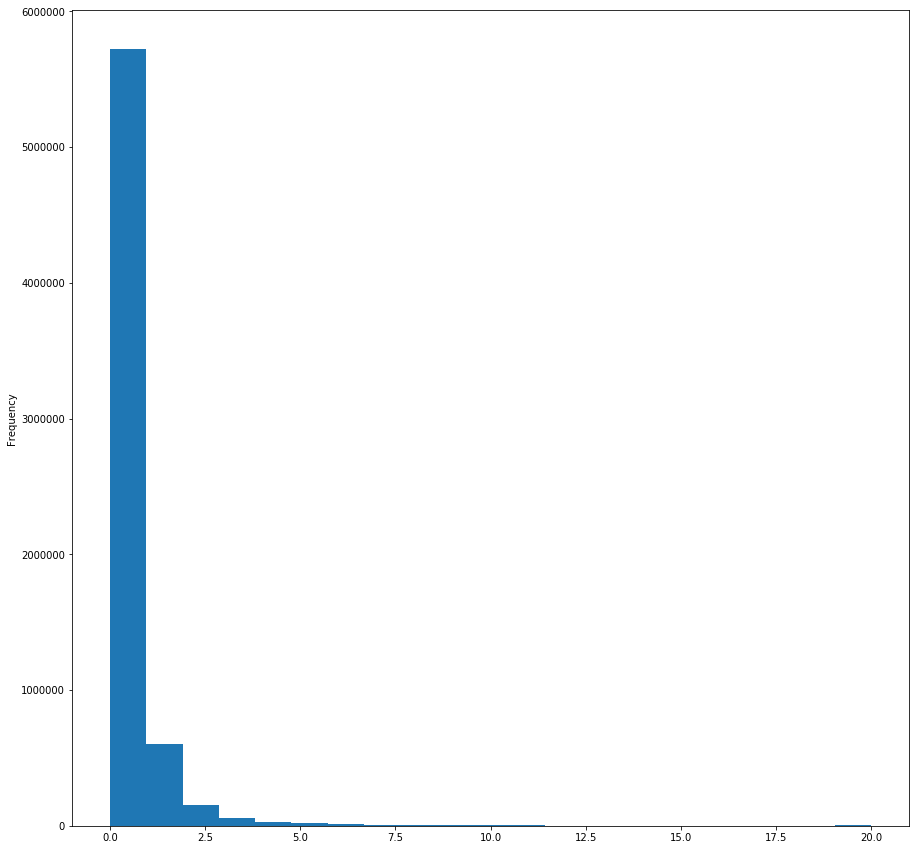

In [107]:
all_data['target'].plot.hist(bins=21, figsize=(15,15))

Clearly, for most of combinations of shop, item and month either zero or low number of items was sold. 

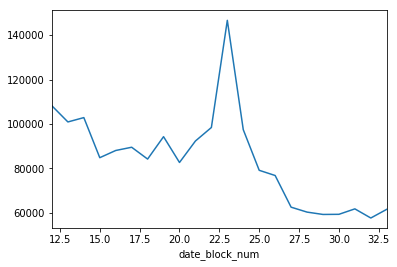

In [109]:
all_data[all_data.date_block_num!=34].groupby(['date_block_num'])['target'].sum().plot()

In time trand we can see a peak around previous New year. Since we are predicting sales for november, they are supposed to be higher than for previous month.

To visualise data I tried tSNE for a subset of data.

In [21]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [30]:
sdata = shuffle(all_data, random_state=321)

In [42]:
subset_l  = 10000
selected_features = [list(all_data.columns.values)[2]] + list(all_data.columns.values)[4:-1]  
data_subset = scale(sdata[selected_features][:subset_l])
response_subset = sdata["target"][:subset_l]

In [ ]:
tsne = TSNE(random_state = 321, perplexity=50)
tsne_representation = tsne.fit_transform(data_subset)

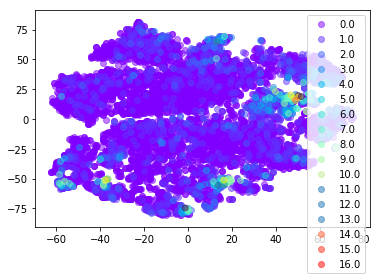

In [44]:
colors = cm.rainbow(np.linspace(0, 1, len(set(response_subset))))
for y, c in zip(set(all_data.target), colors):
    plt.scatter(tsne_representation[response_subset.values==y, 0], 
                tsne_representation[response_subset.values==y, 1], c=c, alpha=0.5, label=str(y))
plt.legend()

This picture shows that objects with higher cumulative month sales tend to group together in small parts of tSNE-transformed space. So tSNE transformed features could be useful at least for discrimination of such good-celled items. Unfortunately, I didn't have time to generate such features for the whole dataset. 

Let's make simple prediction, using previous month data.

In [122]:
pred_df = test[['ID', 'shop_id', 'item_id']]

In [124]:
pred_pf = pd.merge(pred_df, X_prev_month, how='left', on=['shop_id', 'item_id']).fillna(0)

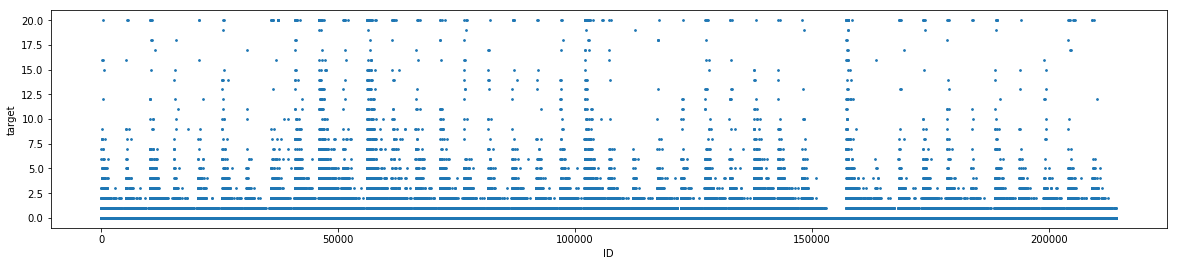

In [133]:
pred_pf.plot.scatter(x='ID', y='target', s=3, figsize=(20,4))

Although our prediction is not that good, we can clearly see a structure here. If we examine the order of shop and item ids in test data, we would see, that we have blocks for same shop of length 5100. And inside this block follows items in same order for each block. Here we can see, that results for all 42 shops looks quite similar (excluding shop with id 30, for which we haven't got information from previous month). At the beginning of each shop section there is a peak, and later target decreases. Thus, item id seems to be more important, than shop id, because shops are rather similar in their target distributions. I don't know, if this can be considered as data leakage, but I kind of used it when making rather large number of features, describing items. I used Tfidf with svd for that purpose.

## Processing of item names

Next I created Tfidf features for items names. I used ngrams instead of words, in hope that it will help me to deal with some strange signs and notations, present in items names.

In [ ]:
items_texts = items.iloc[:,0].values.tolist()

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 9))
X = vectorizer.fit_transform(items_texts)

c:\users\julia\appdata\local\programs\python\python35\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [35]:
X.shape

(22170, 1274132)

Then I used svd to decrease dimensionality - from 1274132 features to 100.

In [36]:
from sklearn.decomposition import TruncatedSVD

In [37]:
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X)

In [38]:
X_svd = pd.DataFrame(X_svd, columns=[str(x) for x in range(100)])
items = pd.concat([items, X_svd], axis=1, join='outer', join_axes=None, 
          keys=None, levels=None)

Then I merged dataframe with all features with manually created features form shops dataframe and Tfidf svd-transformed features for items.

In [16]:
all_data = pd.merge(all_data, shops.drop(['shop_name'],axis=1), how='left', on='shop_id')
all_data = downcast_dtypes(all_data)

In [18]:
item_svd_mapping = items.drop_duplicates()
all_data = pd.merge(all_data, item_svd_mapping, how='left', on='item_id')

In [19]:
del items
del item_svd_mapping

In [23]:
all_data.shape

(6639294, 131)

Alltogether I got 131 features. Then I make train/test split. I used last month with date_block_num=33 as validation set.

## Train/test split

In [21]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

test_block = 33
last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 34


In [22]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == test_block]
dates_final_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == test_block].drop(to_drop_cols, axis=1)
X_final_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == test_block, 'target'].values
y_final_test =  all_data.loc[dates == last_block, 'target'].values

In [23]:
del all_data

## Training of first-level models

Then I trained my first-level models - lightgdm gradient boosting and random forest. After some test I selected these parameters:

In [24]:
lgb_params = {
               'feature_fraction': 0.75,
               'categorical_feature':[21,22,23,24,25],
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))
np.sqrt(mean_squared_error(y_test, pred_lgb))

Test R-squared for LightGBM is 0.493805


0.808344455004763

In [25]:
with open('lgb.pkl', 'wb') as f:
    pickle.dump(model, f)

In [182]:
rf = RandomForestRegressor(criterion='mse',
                           max_leaf_nodes=None,
                           n_estimators=50,
                           min_impurity_split=0.0000001,
                           n_jobs=2,
                           max_features=0.6,
                           max_depth=20,
                           min_samples_leaf=1,
                           min_samples_split=2,
                           min_weight_fraction_leaf=0.0,
                           bootstrap=False,
                           random_state=1,
                           verbose=False)
rf.fit(X_train.values, y_train)
pred_rf = rf.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_rf))
np.sqrt(mean_squared_error(y_test, pred_rf))

c:\users\julia\appdata\local\programs\python\python35\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
c:\users\julia\appdata\local\programs\python\python35\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
c:\users\julia\appdata\local\programs\python\python35\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
c:\users\julia\appdata\local\programs\python\python35\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be remo

Test R-squared for linreg is 0.692275


0.6302582717826003

In [183]:
with open('rf.pkl', 'wb') as f:
    pickle.dump(rf, f)

Here I got predictions for test data of first level models:

In [51]:
pred_final_rf = rf.predict(X_final_test.values)
pred_final_lgb = model.predict(X_final_test)

These model themselves showed good results (especially lightgbm), but ensembling helped me to advance a bit.

## Ensembling

Next I worked on ensembling. Here I create matrices of predictions for validation and test.

In [ ]:
X_test_level2 = np.c_[pred_rf, pred_lgb] 
X_test_final_level2 = np.c_[pred_final_rf, pred_final_lgb] 

I didn't have much time for computations, so I created metafeatures for only 3 months.

In [31]:
dates_train_level2 = dates_train[dates_train.isin([30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([30, 31, 32])]

In [ ]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [30, 31, 32]:        
    X_tr = X_train.loc[dates_train <  cur_block_num]
    X_te =  X_train.loc[dates_train == cur_block_num]
    y_tr = y_train[dates_train < cur_block_num]
    
    lr_f = RandomForestRegressor(criterion='mse',
                           max_leaf_nodes=None,
                           n_estimators=50,
                           min_impurity_split=0.0000001,
                           n_jobs=2,
                           max_features=0.6,
                           max_depth=20,
                           min_samples_leaf=1,
                           min_samples_split=2,
                           min_weight_fraction_leaf=0.0,
                           bootstrap=False,
                           random_state=1,
                           verbose=False)
    lr_f.fit(X_tr.values, y_tr)
    pred_lr_f = lr_f.predict(X_te.values)
    
    model_f = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 100)
    pred_lgb_f = model_f.predict(X_te)
    
    X_train_level2[np.where(dates_train_level2==cur_block_num),0] = pred_lr_f
    X_train_level2[np.where(dates_train_level2==cur_block_num),1] = pred_lgb_f

Then I tried to make linear combination of features.

In [64]:
alphas_to_try = np.linspace(0, 1, 1001)
rmse_scores = np.zeros(alphas_to_try.shape[0])

best_alpha, rmse_train_simple_mix = 0, 100
a_lst = []
for ind, a in enumerate(alphas_to_try):
    mix = (a * X_train_level2[:,0]) + ((1 - a) * X_train_level2[:,1])
    rmse_scores_cur= np.sqrt(mean_squared_error(y_train_level2, mix))
    a_lst.append(rmse_scores_cur)
    if rmse_scores_cur < rmse_train_simple_mix:
        best_alpha, rmse_train_simple_mix = a, rmse_scores_cur

print('Best alpha: %f; Corresponding rmse score on train: %f' % (best_alpha, rmse_train_simple_mix))

Best alpha: 0.086000; Corresponding rmse score on train: 0.770805


In [65]:
mix = (0.086000 * X_test_level2[:,0]) + ((1 - 0.086000) * X_test_level2[:,1])
np.sqrt(mean_squared_error(y_test, mix))

0.7852464476411968

Then I tried to use linear regression for ensembling.

In [44]:
lr_meta = LinearRegression()
lr_meta.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [184]:
with open('lr_meta.pkl', 'wb') as f:
    pickle.dump(lr_meta, f)

In [48]:
test_preds = lr_meta.predict(X_test_level2)
np.sqrt(mean_squared_error(y_test, test_preds))

0.7898891171324133

Simple mix gave a bit better results than linear meta-model in validation.

I then made predictions for test and clipped them to [0, 20] range.

In [ ]:
mix_preds = (0.086000 * X_test_final_level2[:,0]) + ((1 - 0.086000) * X_test_final_level2[:,1])
meta_preds = lr_meta.predict(X_test_final_level2)

In [ ]:
meta_preds_clipped = [i if i > 0 else 0 for i in meta_preds]
meta_preds_clipped = [i if i < 20 else 20 for i in meta_preds_clipped]
mix_preds_clipped = [i if i > 0 else 0 for i in mix_preds]
mix_preds_clipped = [i if i < 20 else 20 for i in mix_preds_clipped]

Predictions looked similar for simple mix and linear meta-model, though meta-model tended to predict higher values for largest total sales.

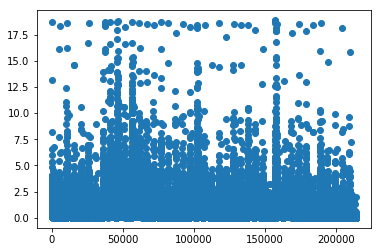

In [76]:
plt.scatter(test.ID.values, mix_preds_clipped)

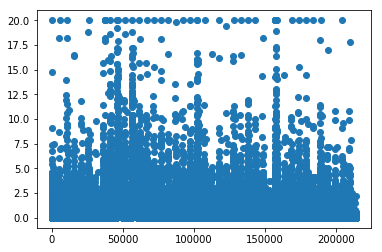

In [77]:
plt.scatter(test.ID.values, meta_preds_clipped)

In [ ]:
with open("submission_33.csv", "w") as f:
    f.write("ID,item_cnt_month\n")
    for i in range(test.shape[0]):
        f.write("%d,%.1f\n" % (test.ID[i], mix_preds_clipped[i]))

Simple mix gave a bit better result not only for validation, but also for test. In public test it gave 0.91714 rmse, and last time I checked, I was in 63 place in this competition: https://www.kaggle.com/c/competitive-data-science-final-project/leaderboard.